`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022
 Выпонила: Рудская Ирина
 Вариант №17`   




# Лабораторная работа №4: Методы снижения размерности. Регуляризация логистической регрессии. 

В практических примерах ниже показано:   

* как снижать размерность пространства признаков методами главных компонент (PCR)
* как строить логистическую регрессию с регуляризацией параметров (метод ридж) 

Точность всех моделей оценивается методом перекрёстной проверки по 10 блокам.  

*Модели*: множественная линейная регрессия 

*Данные*: `default_of_credit_card_clients` 

*Источник*: https://github.com/aksyuk/MTML/blob/main/Labs/data/default_of_credit_card_clients.csv

# Указания к выполнению


## Загружаем пакеты

In [153]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  стандартизация показателей
from sklearn.preprocessing import StandardScaler
#  метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
#  логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
#  перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
#  расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report

In [154]:
# константы
#  ядро для генератора случайных чисел
my_seed = 17
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [155]:
# функция, которая строит график сжатия коэффициентов в ридж и лассо
#  из репозитория к книге С.Рашки Python и машинное обучение,
#  слегка переработанная
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names,
                        C_min_pow=-4, C_max_pow=3.) :
    fig = plt.figure()
    ax = plt.subplot(111)    
    
    # палитра
    colors = sns.color_palette("Spectral", len(col_names)-1)
    
    weights, params = [], []
    for c in np.arange(C_min_pow, C_max_pow+1):
        lr = LogisticRegression(penalty=penalty_name, 
                                C=10.**c, solver='liblinear', 
                                multi_class='ovr', random_state=my_seed)
        lr.fit(X, y)
        weights.append(lr.coef_[class_number])
        params.append(10**c)

    weights = np.array(weights)

    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column],
                 label=col_names[column],
                 color=color)

    # отсечки по оптимальным C
    plt.axvline(x=C_opt[class_number], color='magenta', 
                linestyle='--', linewidth=1)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center', 
              bbox_to_anchor=(1.38, 1.03),
              ncol=1, fancybox=True)
    plt.show()

## Загружаем данные

Данные по кредитам 30000 клиентов банков Тайваня (статистика 2005 года). Задача: спрогнозировать дефолт платежа в следущем месяце по статистике за 6 предыдущих месяцев и по общим сведениям о клиенте. Источник данных: статья Yeh, I. C., & Lien, C. H. The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480. Набор данных был загружен из репозитория UCI (https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) 12.10.2021.

* `LIMIT_BAL` – размер выданного кредита (новых тайваньских долларов);
* `SEX` – пол: 1 = мужской, 2 = женский;
* `EDUCATION` – образование: 1 = аспирантура, 2 = университет, 3 = старшая школа, 4 = другое;
* `MARRIAGE` – семейное положение: 1 = женат/замужем, 2 = одинок, 3 = другое;
* `AGE` – возраст, лет;
* `PAY_0`, `PAY_2`, ..., `PAY_6` – статус последних ежемесячных платежей, с сентября (`PAY_0`) по апрель (`PAY_6`) 2005 года: -1 = платёж внесён вовремя, 1 = платёж внесён с опозданием на 1 месяц; 2 = с опозданием на 2 месяца, и т.д., 9 = с опозданием на 9 месяцев и более;
* `BILL_AMT1`, ..., `BILL_AMT6` – размер последних ежемесячных платежей (новых тайваньских долларов), с сентября (`BILL_AMT1`) по апрель (`BILL_AMT6`) 2005 года;
* `PAY_AMT1`, ..., `PAY_AMT6` – размер ежемесячных платежей в предыдущем месяце (новых тайваньских долларов), с сентября (`PAY_AMT1` за август) по апрель (`PAY_AMT6` за март) 2005 года;
* `Y` – целевая переменная: дефолт в следующем месяце (1 – да, 0 – нет).

Зависимая переменная: `Y`

Объясняющие переменные все, кроме: 
`Y`,`PAY_4`, `PAY_5`, `PAY_6`, `BILL_AMT4`, `BILL_AMT5`, `BILL_AMT6`, `PAY_AMT1`, ..., `PAY_AMT6`


Загружаем данные во фрейм и выясняем их размерность.  

In [156]:
# загружаем таблицу и превращаем её во фрейм
DF_all = pd.read_csv('https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/default_of_credit_card_clients.csv')

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (30000, 24)


In [157]:
# выбираем нужные значения
DF_all = DF_all.drop(["PAY_4", "PAY_5", "PAY_6", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", 
                      "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6",], axis = 1)

In [158]:
# для проверки
DF_all.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3,Y
0,20000,2,2,1,24,2,2,-1,3913,3102,689,1
1,120000,2,2,2,26,-1,2,0,2682,1725,2682,1
2,90000,2,2,2,34,0,0,0,29239,14027,13559,0
3,50000,2,2,1,37,0,0,0,46990,48233,49291,0
4,50000,1,2,1,57,-1,0,-1,8617,5670,35835,0


Отложим 15% наблюдений для прогноза.  

In [159]:
# наблюдения для моделирования
DF = DF_all.sample(frac = 0.85, random_state = my_seed)
# отложенные наблюдения
DF_predict = DF_all.drop(DF.index)

In [160]:
# первые 5 строк фрейма 
DF.iloc[:, :12].head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3,Y
15854,130000,2,2,1,27,0,0,0,76885,79106,81231,0
7388,150000,1,3,2,41,0,0,0,64425,57073,32516,0
1799,130000,1,3,2,28,0,0,0,132258,133781,133834,0
735,70000,2,3,1,50,-2,-2,-1,27345,-1041,17571,0
22485,20000,2,2,1,43,0,0,0,11511,12521,13851,0


In [161]:
# типы столбцов фрейма
DF.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
Y            int64
dtype: object

Проверим, нет ли в таблице пропусков.  

In [162]:
# считаем пропуски в каждом столбце
DF.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
Y            0
dtype: int64

Пропусков не обнаружено.  

# Предварительный анализ данных  

## Описательные статистики  

Считаем доли классов целевой переменной `Y`.  

In [163]:
# метки классов
DF.Y.unique()

array([0, 1], dtype=int64)

In [164]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 3)

0    0.779
1    0.221
Name: Y, dtype: float64

Рассчитаем для объясняющих переменных набора данных описательные статистики. Среди них есть категориальные.

In [165]:
# описательные статистики
DF.iloc[:, :6].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0
count,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000
mean,168409.791373,1.603137,1.852471,1.551451,35.500902,-0.017569
std,130337.089250,0.489257,0.790870,0.521452,9.229607,1.126114
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000


In [166]:
# описательные статистики
DF.iloc[:, 6:11].describe()

,PAY_2,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3
count,25500.000000,25500.000000,25500.000000,25500.000000,2.550000e+04
mean,-0.137882,-0.164980,51278.389451,49240.652980,4.709367e+04
std,1.197557,1.198796,74022.431117,71578.915669,6.977306e+04
min,-2.000000,-2.000000,-165580.000000,-67526.000000,-1.572640e+05
25%,-1.000000,-1.000000,3577.750000,2990.000000,2.691000e+03
50%,0.000000,0.000000,22137.000000,20897.000000,2.003500e+04
75%,0.000000,0.000000,66855.500000,63620.250000,5.994600e+04
max,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06


Выводы по описательным статистикам: стоит заметить, что значения объясняющих переменных как положительные, так и отрицательные (из-за смысловой нагрузки категориальных переменных); масштабы измерения отличаются. Для работы с методами снижения размерности и регуляризации понадобится стандартизация значений.   

## Визуализация разброса переменных внутри классов  

Поскольку в наборе данных 11 объясняющих переменных, анализ матричного графика разброса будет затруднительным. Построим коробчатые диаграммы для объясняющих переменных, чтобы сравнить средние уровни и разброс по классам.  

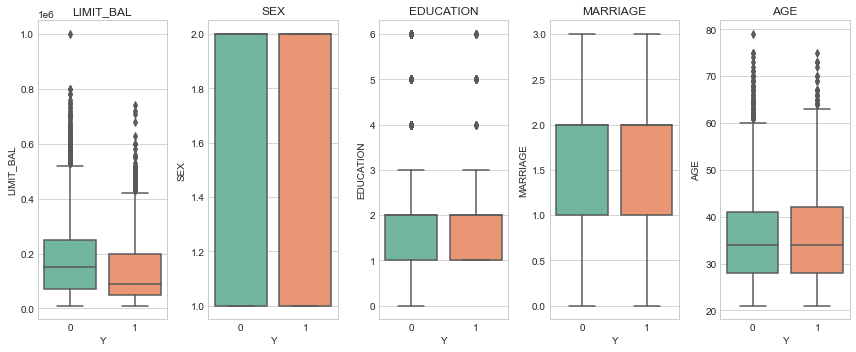

In [167]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[:5].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

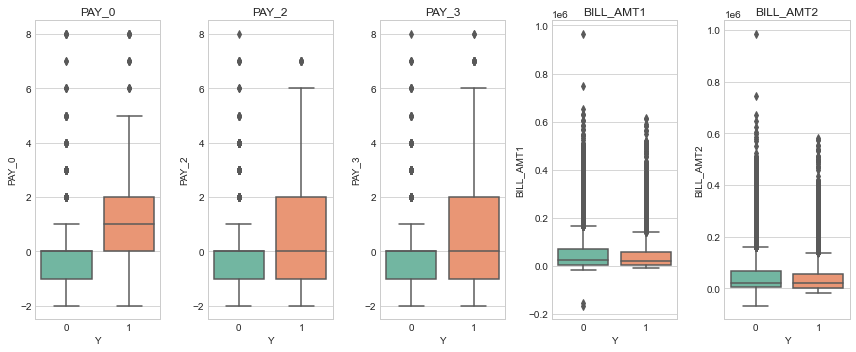

In [168]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop =  list(DF.columns[5:10].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

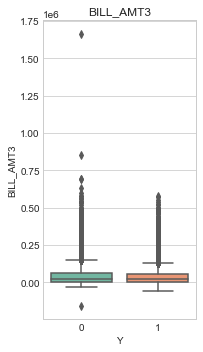

In [169]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])

axs = [ax1]

cols_loop = list(DF.columns[10:11].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

Следует учесть, что в модели есть категориальные переменные, например, `sex`, `education` и т. д., на графиках у непрерывных переменных отличие в медианах и разбросе между классами прослеживается. Это говорит о том, классы по зависимой переменной Y неплохо разделяются по всем объясняющим переменным.

## Корреляционный анализ   

Теперь посмотрим на взаимодействие объясняющих переменных.  

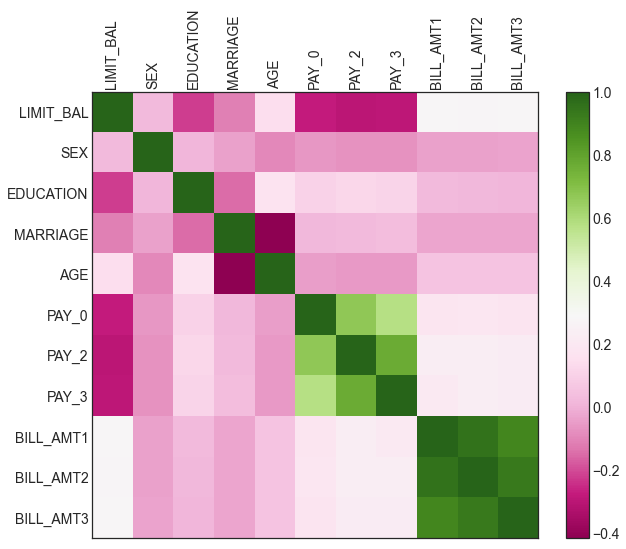

In [170]:
# рассчитываем корреляционную матрицу
corr_mat = DF.drop('Y', axis=1).corr()
col_names = DF.drop('Y', axis=1).columns

# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')

# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

Между объясняющими переменными обнаруживаются как прямые, так и обратные линейные взаимосвязи. Выведем все значимые коэффициенты в одной таблице и определим минимальный / максимальный из них.     

In [171]:
# делаем фрейм из корреляционной матрицы и стираем диагональные значения
#  и нижний треугольник матрицы
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
# меняем размерность с матрицы на таблицу: показатель 1, показатель 2,
#  корреляция
df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']
# считаем двусторонние p-значения для проверки значимости
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция.values ** 2))
df['P_значение'] = 2*(1 - t.cdf(abs(t_stat), len(DF.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
#  выводим все значимые с сортировкой
df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')

,Показатель_1,Показатель_2,Корреляция,P_значение
27,MARRIAGE,AGE,-0.415197,0.0
5,LIMIT_BAL,PAY_2,-0.296231,0.0
6,LIMIT_BAL,PAY_3,-0.288631,0.0
4,LIMIT_BAL,PAY_0,-0.272081,0.0
1,LIMIT_BAL,EDUCATION,-0.220484,0.0
19,EDUCATION,MARRIAGE,-0.147249,0.0
2,LIMIT_BAL,MARRIAGE,-0.108562,0.0
12,SEX,AGE,-0.089339,0.0
14,SEX,PAY_2,-0.071376,0.0
15,SEX,PAY_3,-0.068041,0.0


# Методы снижения резмерности  

Посмотрим, как работает метод снижения размерности:  

* регрессия на главные компоненты (PCR)     

Метод требует предварительной стандартизации переменных.  

In [172]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF.iloc[:, :11].values)

# проверяем средние и стандартные отклонения после стандартизации
for i_col in range(X_train_std.shape[1]) :
    print('Столбец ', i_col, ': среднее = ',
          np.round(np.mean(X_train_std[:, i_col]), 2),
         '   Станд. отклонение = ', 
          np.round(np.std(X_train_std[:, i_col]), 2), sep='')

Столбец 0: среднее = -0.0   Станд. отклонение = 1.0
Столбец 1: среднее = 0.0   Станд. отклонение = 1.0
Столбец 2: среднее = 0.0   Станд. отклонение = 1.0
Столбец 3: среднее = 0.0   Станд. отклонение = 1.0
Столбец 4: среднее = 0.0   Станд. отклонение = 1.0
Столбец 5: среднее = -0.0   Станд. отклонение = 1.0
Столбец 6: среднее = 0.0   Станд. отклонение = 1.0
Столбец 7: среднее = 0.0   Станд. отклонение = 1.0
Столбец 8: среднее = -0.0   Станд. отклонение = 1.0
Столбец 9: среднее = -0.0   Станд. отклонение = 1.0
Столбец 10: среднее = 0.0   Станд. отклонение = 1.0


## Регрессия на главные компоненты (PCR)  

Пересчитаем объясняющие показатели в главные компоненты.  

In [173]:
# функция с методом главных компонент
pca = PCA()
# пересчитываем в главные компоненты (ГК)
X_train_pca = pca.fit_transform(X_train_std)

# считаем доли объяснённой дисперсии
frac_var_expl = pca.explained_variance_ratio_
print('Доли объяснённой дисперсии по компонентам в PLS:\n',
     np.around(frac_var_expl, 3),
     '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.301 0.214 0.137 0.093 0.083 0.052 0.048 0.04  0.02  0.01  0.004] 
Общая сумма долей: 1.0


Главные компоненты взаимно ортогональны, убедимся в этом.  

In [174]:
# ГК ортогональны – убедимся в этом, рассчитыв корреляционную матрицу
corr_mat = pd.DataFrame(X_train_pca).corr()
np.around(corr_mat, 2)

,0,1,2,3,4,5,6,7,8,9,10
0,1.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
1,-0.0,1.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2,-0.0,0.0,1.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0
3,0.0,0.0,-0.0,1.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
5,-0.0,-0.0,0.0,-0.0,-0.0,1.0,-0.0,-0.0,0.0,-0.0,0.0
6,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,0.0,-0.0,0.0,-0.0
7,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,1.0,0.0,0.0,0.0
8,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,1.0,-0.0,0.0
9,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,1.0,-0.0


Построим график объяснённой дисперсии. 

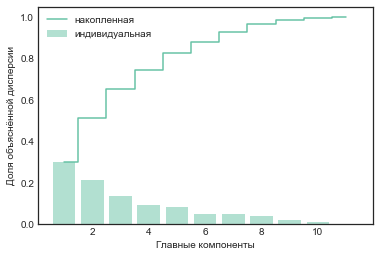

In [175]:
# график объяснённой дисперсии
plt.bar(range(1, 12), pca.explained_variance_ratio_, alpha=0.5, 
        align='center', label='индивидуальная')
plt.step(range(1, 12), np.cumsum(pca.explained_variance_ratio_), 
         where='mid', label='накопленная')
plt.ylabel('Доля объяснённой дисперсии')
plt.xlabel('Главные компоненты')
plt.legend()
plt.show()

Столбцы на графике показывают долю исходной дисперсии исходных переменных, которую объясняет главная компонента. Линией показана накопленная доля. Так, видно, что первые 5 компонент объясняют чуть больше 80% исходной дисперсии $X$.   
Чтобы увидеть, как классы выглядят в координатах ГК на графике, придётся сократить пространство для двух компонент, которые объясняют 52% разброса объясняющих переменных.   

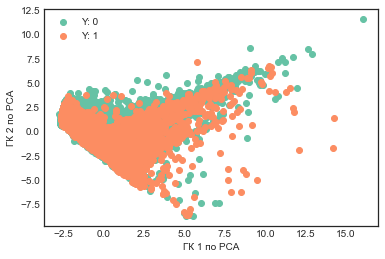

In [176]:
# пересчитываем X в 2 ГК
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)

# график классов в пространстве ГК
plt.scatter(X_train_pca[DF['Y'] == 0][:, 0], 
            X_train_pca[DF['Y'] == 0][:, 1], label='Y: 0')
plt.scatter(X_train_pca[DF['Y'] == 1][:, 0], 
            X_train_pca[DF['Y'] == 1][:, 1], label='Y: 1')

plt.xlabel('ГК 1 по PCA')
plt.ylabel('ГК 2 по PCA')
plt.legend()
plt.show()

Судя по графику, классы не очень хорошо разделяются в пространстве двух главных компонент, но разделение есть. Построим логистическую регрессию и оценим её точность с помощью перекрёстной проверки.  

In [177]:
# функция оценки логистической регрессии
logit = LogisticRegression()
# функция разбиения на блоки для перекрёстной проверки
kf_10 = KFold(n_splits=10, random_state=my_seed, shuffle=True) 
# считаем точность модели (Acc) с перекрёстной проверкой по блокам
score = list()
acc = cross_val_score(logit, X_train_pca, DF.Y.values, cv=kf_10,
 scoring='accuracy').mean()

score.append(np.around(acc, 3))
score_models = list()
score_models.append('logit_PC2')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', np.around(score[0], 2), sep='')

Модель logit_PC2, перекрёстная проверка по 10 блокам
Acc = 0.8


# Методы сжатия  

## Ридж-регрессия  

Функция `LogisticRegression()` умеет работать с мультиклассовой классификацией, используя при оценке параметров подход **один класс против остальных**. Построим ридж на наших данных.  

In [178]:
# функция для построения модели
logit_ridge = LogisticRegression(penalty='l2', solver='liblinear')
# оцениваем параметры
logit_ridge.fit(X_train_std, Y_train)
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_ridge.intercept_, 3),
     '\nКоэффициенты моделей для классов:\n', np.around(logit_ridge.coef_, 3))

Константы моделей для классов:
 [-1.437] 
Коэффициенты моделей для классов:
 [[-0.157 -0.041 -0.081 -0.092  0.064  0.682  0.109  0.141 -0.151  0.028
  -0.049]]


Подбираем гиперпараметр регуляризации $\lambda$ с помощью перекрёстной проверки. В функции 
`LogisticRegression()` есть аргумент $C$ – это инверсия гиперпараметра $\lambda$.   

In [179]:
# поиск оптимального значения C:
#  подбираем C по наибольшей точности с перекрёстной проверкой
ridge_cv = LogisticRegressionCV(cv=10, random_state=my_seed+2, 
                                penalty='l2', solver='liblinear')
ridge_cv.fit(X_train_std, Y_train)
# значения параметра C (инверсия лямбды), которые дают наилучшую
#  точность для каждого класса
ridge_cv.C_

array([0.35938137])

In [180]:
# сохраняем и выводим Acc для модели
score.append(np.around(ridge_cv.score(X_train_std, Y_train), 3))
score_models.append('logit_ridge')
print('Модель ', score_models[1], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', score[1], sep='')

Модель logit_ridge, перекрёстная проверка по 10 блокам
Acc = 0.81


Изобразим изменение коэффициентов ридж-регрессии на графике и сделаем отсечку на уровне оптимального параметра $C$.  

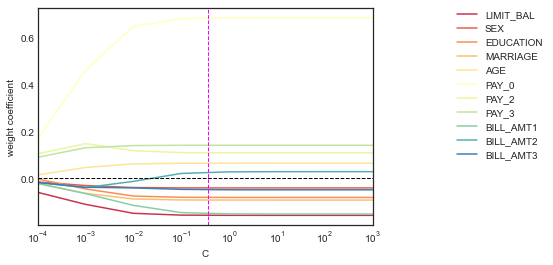

In [181]:
# график динамики коэффициентов в ридж-регрессии    
#  модель для класса 0
plot_coeffs_traces(X_train_std, Y_train, 0, 'l2', ridge_cv.C_, DF.columns)

Итак, судя по графику, для значения гиперпараметра, дающего самую точную модель, ни один коэффициент при объясняющих переменных не обнуляется. Это подтверждает наблюдение, сделанное нами ещё на этапе предварительного анализа: все объясняющие переменные неплохо разделяют классы.   


# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [182]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,logit_PC2,0.798
1,logit_ridge,0.810


Все модели показывают высокую точность по показателю $Acc$, при этом самой точной оказывается ридж-регрессия. Сделаем прогноз на отложенные наблюдения.   

In [183]:
# формируем объекты с данными отложенной выборки
X_pred_std = sc.fit_transform(DF_predict.iloc[:, :11].values)
Y_pred = DF_predict.Y
Y_hat = logit_ridge.predict(X_pred_std)
# отчёт по точности на отложенных наблюдениях
print(classification_report(Y_pred, Y_hat))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      3503
           1       0.71      0.24      0.36       997

    accuracy                           0.81      4500
   macro avg       0.76      0.61      0.62      4500
weighted avg       0.79      0.81      0.77      4500



Итак, методом логистической регрессии со сжатием коэффициенты с L2-регуляризацией мы получили достаточно точную модель классификации дефолта в следующем месяце.  

# Источники 

1. *Рашка С.* Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.  
1. Репозиторий с кодом к книге *Рашка С.* Python и машинное обучение / github.com. URL: <https://github.com/rasbt/python-machine-learning-book-3rd-edition>  
1. *Xueting Bai*, *Lingbo Wang*, *Hanning Li* Identification of red wine categories based on physicochemical properties / 2019 5th International Conference on Education Technology, Management and Humanities Science (ETMHS 2019). URL: <https://webofproceedings.org/proceedings_series/ESSP/ETMHS%202019/ETMHS19309.pdf>  

